In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

/opt/conda/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import matplotlib.pyplot as plt

class DifferentiableSpline:
    def __init__(self, control_points, canvas_size=(128, 128), device='cpu'):
        self.device = device
        self.canvas_size = canvas_size
        self.control_points = control_points.to(device).detach().requires_grad_(True)

    def interpolate_points(self, num_points=100):
        t_values = torch.linspace(0, 1, num_points, device=self.device, requires_grad=True)

        # Ensure exactly 3 control points for Quadratic Bezier curve
        if len(self.control_points) != 3:
            raise ValueError("Need exactly 3 control points for Quadratic Bezier spline interpolation")

        # Define control points for the Quadratic Bezier curve
        p0, p1, p2 = self.control_points

        # Use Quadratic Bezier formula
        points = []
        for t in t_values:
            # Quadratic Bezier formula
            interpolated_point = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2
            points.append(interpolated_point)

        interpolated_points = torch.stack(points) * torch.tensor(self.canvas_size, device=self.device)
        return interpolated_points

    def generate_spline_canvas(self, colors, brush_sizes, num_points=300, test_mode=False):
        colors = colors.to(self.device)
        brush_sizes = brush_sizes.to(self.device)  # Adjust brush size multiplier for more presence

        canvas = torch.zeros((1, 3, *self.canvas_size), device=self.device, requires_grad=True)
        points = self.interpolate_points(num_points=num_points)

        for i, point in enumerate(points):
            X, Y = torch.meshgrid(torch.arange(self.canvas_size[0], device=self.device),
                                  torch.arange(self.canvas_size[1], device=self.device))
            dist_squared = (X - point[0]) ** 2 + (Y - point[1]) ** 2
            gaussian_mask = torch.exp(-dist_squared / (0.005 * brush_sizes[0] ** 2))  # Sharper strokes

            if test_mode:
                print(f"Dist Squared Min: {dist_squared.min().item()}, Max: {dist_squared.max().item()}")
                print(f"Gaussian Mask Min: {gaussian_mask.min().item()}, Max: {gaussian_mask.max().item()}")

            color = colors[i % len(colors)]
            colored_brush = gaussian_mask * color.view(3, 1, 1)

            # Instead of blending, take the max at each pixel to layer the strokes
            canvas = torch.max(canvas, colored_brush.unsqueeze(0))

        if test_mode:
            print(f"Canvas Min: {canvas.min().item()}, Max: {canvas.max().item()}")
        return torch.clamp(canvas, 0, 1)  # Clamp final result to [0, 1]

    def show_canvas(self, canvas):
        canvas_np = canvas.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
        plt.imshow(canvas_np)
        plt.axis('off')
        plt.show()

Control Points: tensor([[0.6788, 0.9105],
        [0.4091, 0.8577],
        [0.5377, 0.8186]], device='cuda:0')
Color: tensor([0.1442, 0.2442, 0.0283], device='cuda:0')
Brush Size: 11.12713336653453
Control Points: tensor([[0.0234, 0.8429],
        [0.4707, 0.8201],
        [0.7683, 0.9202]], device='cuda:0')
Color: tensor([0.7464, 0.4628, 0.1263], device='cuda:0')
Brush Size: 7.944316318969218
Control Points: tensor([[0.1997, 0.6298],
        [0.2025, 0.6415],
        [0.3333, 0.1135]], device='cuda:0')
Color: tensor([0.1038, 0.3717, 0.8783], device='cuda:0')
Brush Size: 9.272203105683229
Control Points: tensor([[0.0964, 0.3382],
        [0.2396, 0.0494],
        [0.8464, 0.6930]], device='cuda:0')
Color: tensor([0.9456, 0.1291, 0.2799], device='cuda:0')
Brush Size: 14.77801959050483
Control Points: tensor([[0.2067, 0.6659],
        [0.4426, 0.7306],
        [0.0081, 0.1861]], device='cuda:0')
Color: tensor([0.0571, 0.6243, 0.1394], device='cuda:0')
Brush Size: 15.6871793639437
Contro

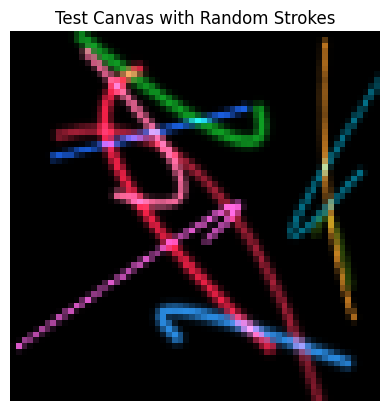

In [4]:
import torch
import matplotlib.pyplot as plt
import random

# Create a function to visualize a test canvas with random colors and brush sizes
def test_random_strokes_on_canvas(canvas_size=(64, 64), num_strokes=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_canvas = torch.zeros((1, 3, *canvas_size), device=device)

    # Generate random control points, colors, and brush sizes for testing
    for _ in range(num_strokes):
        # Random control points within [0, 1] range
        control_points = torch.rand((3, 2), device=device)
        
        # Random color (bright) within [0.5, 1] range
        color = torch.rand(3, device=device)
        
        # Random brush size within a large range
        brush_size = random.uniform(5, 20)
        
        # Print control points, color, and brush size for verification
        print("Control Points:", control_points)
        print("Color:", color)
        print("Brush Size:", brush_size)


        # Initialize the spline with random control points
        spline = DifferentiableSpline(control_points=control_points, canvas_size=canvas_size, device=device)
        
        # Generate the stroke canvas with random color and brush size
        stroke_canvas = spline.generate_spline_canvas(
            colors=color.unsqueeze(0), 
            brush_sizes=torch.full((100,), brush_size, device=device), 
            num_points=100
        )

        # Accumulate the generated stroke on the main test canvas
        test_canvas = torch.clamp(test_canvas + stroke_canvas[0], 0, 1)

    # Visualize the resulting canvas
    canvas_np = test_canvas.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(canvas_np)
    plt.axis('off')
    plt.title("Test Canvas with Random Strokes")
    plt.show()

# Run the test
test_random_strokes_on_canvas()

In [5]:
class StrokePainter(nn.Module):
    def __init__(self, total_strokes, num_control_points_per_stroke=4, hidden_dim=256, n_heads=8, n_enc_layers=3, n_dec_layers=3, canvas_size=(128, 128)):
        super(StrokePainter, self).__init__()
        self.total_strokes = total_strokes
        self.num_control_points_per_stroke = num_control_points_per_stroke
        self.canvas_size = canvas_size

        # Encoder for the input image and canvas
        self.enc_img = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        self.enc_canvas = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        # Convolution layer to combine image and canvas encodings
        self.conv = nn.Conv2d(256, hidden_dim, kernel_size=1)

        # Transformer to generate stroke parameters
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=n_heads, num_encoder_layers=n_enc_layers, num_decoder_layers=n_dec_layers)

        # Linear layers to generate stroke parameters from transformer output
        self.linear_param = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, 2 * num_control_points_per_stroke + 4)
        )

        # Positional embedding for transformer
        self.query_pos = nn.Parameter(torch.rand(total_strokes, hidden_dim))

    def forward(self, img, canvas):
        batch_size, _, H, W = img.shape

        # Encode target image and canvas
        img_feat = self.enc_img(img)
        canvas_feat = self.enc_canvas(canvas)

        # Combine encoded features and apply convolution
        combined_feat = torch.cat([img_feat, canvas_feat], dim=1)
        combined_feat = self.conv(combined_feat).flatten(2)
        combined_feat = combined_feat.permute(2, 0, 1)

        # Transformer input
        hidden_state = self.transformer(combined_feat, self.query_pos.unsqueeze(1).repeat(1, batch_size, 1))
        hidden_state = hidden_state.permute(1, 0, 2)

        # Generate stroke parameters
        stroke_params = self.linear_param(hidden_state)

        # Split stroke parameters into interpretable parts
        control_points = torch.sigmoid(stroke_params[:, :, :2 * self.num_control_points_per_stroke])
        colors = torch.sigmoid(stroke_params[:, :, 2 * self.num_control_points_per_stroke:2 * self.num_control_points_per_stroke + 3])
        brush_sizes = torch.sigmoid(stroke_params[:, :, -1]) * 20
        
        print("Debug info:")
        print(">", stroke_params.shape)
        print("Control Points:", control_points.detach().cpu().numpy())
        print("Colors:", colors.detach().cpu().numpy())
        print("Brush Size:", brush_sizes.detach().cpu().numpy())

        # Reshape control points
        control_points = control_points.view(batch_size, self.total_strokes, self.num_control_points_per_stroke, 2)
        print("Control Points View:", control_points.detach().cpu().numpy())

        # Initialize the canvas and overlap count for each batch item
        accumulated_canvas = torch.zeros((batch_size, 3, *self.canvas_size), device=img.device)
        overlap_count = torch.zeros((batch_size, 1, *self.canvas_size), device=img.device)  # 1-channel for counting overlaps

        for b in range(batch_size):
            for i in range(self.total_strokes):
                # Use control points directly without offsets
                control_point = control_points[b, i]
                color = colors[b, i]
                brush_size = brush_sizes[b, i]
                
                # Print debug information for each stroke
                print(f"Stroke {i + 1}:")
                print("Positioned Control Points:", control_point)
                print("Color:", color)
                print("Brush Size:", brush_size)
                print("SCONTROL", control_point * torch.tensor(self.canvas_size, device=img.device))
                
                # Create the spline for this stroke
                spline = DifferentiableSpline(
                    control_points=control_point,
                    canvas_size=self.canvas_size,
                    device=img.device
                )

                # Render this stroke on a temporary canvas
                stroke_canvas = spline.generate_spline_canvas(color.unsqueeze(0), brush_sizes=torch.full((100,), brush_size.item(), device=img.device), num_points=100)
                
                if torch.all(stroke_canvas == 0):
                    print(f"Warning: Generated stroke_canvas for Stroke {i + 1} is all zeros.")
                
                stroke_canvas_np = stroke_canvas[0].detach().cpu().numpy().transpose(1, 2, 0)
                
                # Plot the stroke canvas
                plt.imshow(stroke_canvas_np)
                plt.title("Generated Stroke Canvas")
                plt.axis('off')
                plt.show()

                # Accumulate the colors and update the overlap count
                accumulated_canvas[b] += stroke_canvas[0]

        # Clamp the final canvas to ensure pixel values are between 0 and 1
        final_canvas = accumulated_canvas

        return final_canvas

Debug info:
> torch.Size([1, 5, 10])
Control Points: [[[0.4297455  0.50112295 0.50178015 0.5602957  0.52753294 0.45513186]
  [0.45751715 0.51864755 0.4868884  0.5322559  0.5171701  0.4652755 ]
  [0.4307118  0.52257705 0.53049296 0.53627104 0.5351071  0.5025785 ]
  [0.3901729  0.5155879  0.5270739  0.5311971  0.54409015 0.49869314]
  [0.46230698 0.48172903 0.5656053  0.5792576  0.53023875 0.46303588]]]
Colors: [[[0.3939507  0.48681673 0.52165586]
  [0.44364288 0.51241237 0.5048381 ]
  [0.4461111  0.50820386 0.5216202 ]
  [0.4840031  0.51852715 0.56529194]
  [0.3897132  0.55107975 0.56484246]]]
Brush Size: [[11.095385 11.072091 10.564329 10.204691 10.506476]]
Control Points View: [[[[0.4297455  0.50112295]
   [0.50178015 0.5602957 ]
   [0.52753294 0.45513186]]

  [[0.45751715 0.51864755]
   [0.4868884  0.5322559 ]
   [0.5171701  0.4652755 ]]

  [[0.4307118  0.52257705]
   [0.53049296 0.53627104]
   [0.5351071  0.5025785 ]]

  [[0.3901729  0.5155879 ]
   [0.5270739  0.5311971 ]
   [0.5440

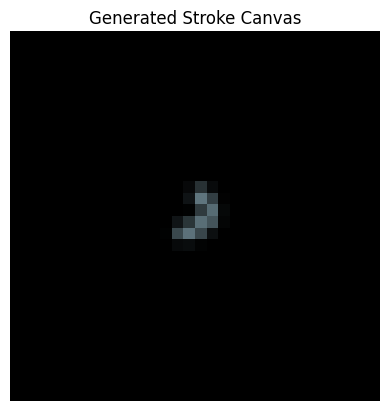

Stroke 2:
Positioned Control Points: tensor([[0.4575, 0.5186],
        [0.4869, 0.5323],
        [0.5172, 0.4653]], grad_fn=<SelectBackward>)
Color: tensor([0.4436, 0.5124, 0.5048], grad_fn=<SelectBackward>)
Brush Size: tensor(11.0721, grad_fn=<SelectBackward>)
SCONTROL tensor([[14.6405, 16.5967],
        [15.5804, 17.0322],
        [16.5494, 14.8888]], grad_fn=<MulBackward0>)


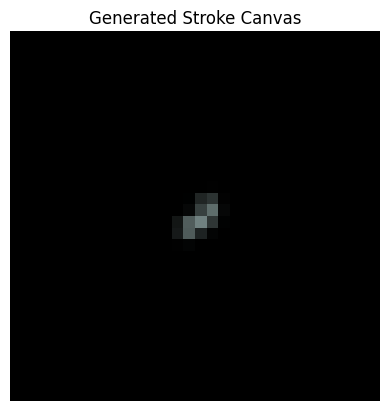

Stroke 3:
Positioned Control Points: tensor([[0.4307, 0.5226],
        [0.5305, 0.5363],
        [0.5351, 0.5026]], grad_fn=<SelectBackward>)
Color: tensor([0.4461, 0.5082, 0.5216], grad_fn=<SelectBackward>)
Brush Size: tensor(10.5643, grad_fn=<SelectBackward>)
SCONTROL tensor([[13.7828, 16.7225],
        [16.9758, 17.1607],
        [17.1234, 16.0825]], grad_fn=<MulBackward0>)


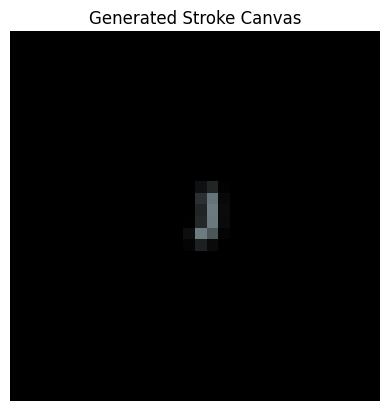

Stroke 4:
Positioned Control Points: tensor([[0.3902, 0.5156],
        [0.5271, 0.5312],
        [0.5441, 0.4987]], grad_fn=<SelectBackward>)
Color: tensor([0.4840, 0.5185, 0.5653], grad_fn=<SelectBackward>)
Brush Size: tensor(10.2047, grad_fn=<SelectBackward>)
SCONTROL tensor([[12.4855, 16.4988],
        [16.8664, 16.9983],
        [17.4109, 15.9582]], grad_fn=<MulBackward0>)


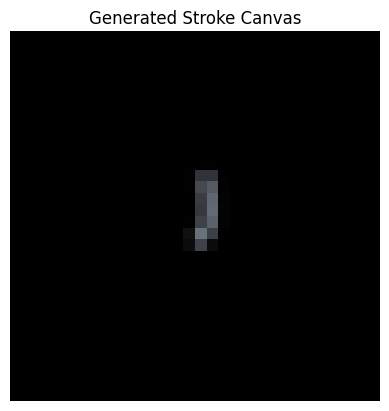

Stroke 5:
Positioned Control Points: tensor([[0.4623, 0.4817],
        [0.5656, 0.5793],
        [0.5302, 0.4630]], grad_fn=<SelectBackward>)
Color: tensor([0.3897, 0.5511, 0.5648], grad_fn=<SelectBackward>)
Brush Size: tensor(10.5065, grad_fn=<SelectBackward>)
SCONTROL tensor([[14.7938, 15.4153],
        [18.0994, 18.5362],
        [16.9676, 14.8171]], grad_fn=<MulBackward0>)


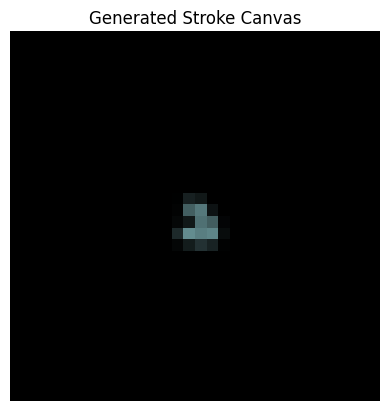

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


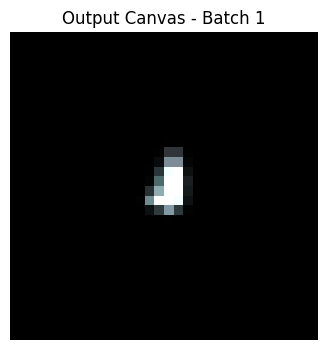

In [6]:
# Test function with the debug-enabled StrokePainter
def test_stroke_painter_canvas_generation():
    total_strokes = 5
    num_control_points_per_stroke = 3
    canvas_size = (32, 32)
    model = StrokePainter(
        total_strokes=total_strokes,
        num_control_points_per_stroke=num_control_points_per_stroke,
        canvas_size=canvas_size
    )

    batch_size = 1
    img = torch.rand(batch_size, 3, *canvas_size)
    canvas = torch.zeros(batch_size, 3, *canvas_size)

    output_canvas = model(img, canvas)

    output_canvas_np = output_canvas.detach().cpu().numpy()
    for i in range(batch_size):
        plt.figure(figsize=(4, 4))
        plt.imshow(output_canvas_np[i].transpose(1, 2, 0))
        plt.axis('off')
        plt.title(f"Output Canvas - Batch {i+1}")
        plt.show()

# Run the test
test_stroke_painter_canvas_generation()

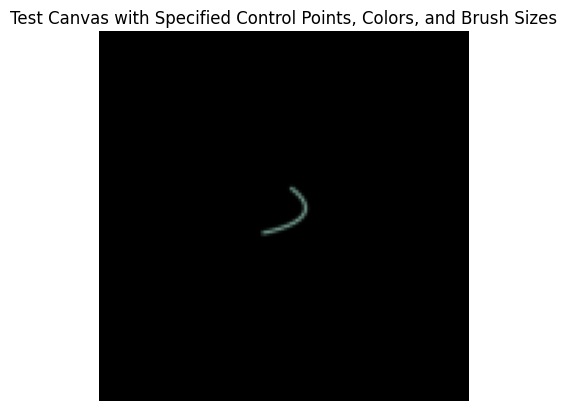

In [50]:
import torch
import matplotlib.pyplot as plt

# Ensure DifferentiableSpline is defined as you expect it to be
# Assuming it has been defined with generate_spline_canvas

# Provided data
control_points = torch.tensor([
    [[0.5419, 0.4421],
    [0.5014, 0.6176],
    [0.4225, 0.5181]]
], device='cuda' if torch.cuda.is_available() else 'cpu')

colors = torch.tensor([
    [0.61218894, 0.26011796, 0.5445522],
], device='cuda' if torch.cuda.is_available() else 'cpu')

brush_sizes = [10.566423]

# Canvas parameters
canvas_size = (128, 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_canvas = torch.zeros((1, 3, *canvas_size), device=device)

# Render each stroke on the canvas
for i, (points, color, brush_size) in enumerate(zip(control_points, colors, brush_sizes)):
    # Initialize the spline with the current set of control points
    spline = DifferentiableSpline(control_points=points, canvas_size=canvas_size, device=device)
    
    # Generate the stroke canvas with the current color and brush size
    stroke_canvas = spline.generate_spline_canvas(
        colors=color.unsqueeze(0),
        brush_sizes=torch.full((100,), brush_size, device=device),
        num_points=100
    )

    # Accumulate the generated stroke on the main test canvas
    test_canvas = torch.clamp(test_canvas + stroke_canvas[0], 0, 1)

# Visualize the resulting canvas
canvas_np = test_canvas.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(canvas_np)
plt.axis('off')
plt.title("Test Canvas with Specified Control Points, Colors, and Brush Sizes")
plt.show()